In [1]:
!pip -q install geopandas shapely rasterio pyproj tqdm

In [2]:
from google.colab import drive
drive.mount('/content/drive')
!ls '/content/drive/MyDrive/CASA0004_Cycling/data'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
BoroughShp
city_of_london_bike_accessible_roads.geojson
COL_cycleavailable.geojson
COL_cyclelane.geojson
Env
greater_london_bike_accessible_roads.geojson
GreatLondonShp
Results
Roads
Slope


In [3]:
import math
import numpy as np
import rasterio
from shapely.geometry import LineString, MultiLineString
from tqdm import tqdm

import geopandas as gpd
import pandas as pd
from shapely.geometry import Point
from shapely.strtree import STRtree
import numpy as np
import matplotlib.pyplot as plt

In [4]:
# 可调参数
SLOPE_TIF = "/content/drive/MyDrive/CASA0004_Cycling/data/Slope/slope_test/slope.tif"
INTERVAL_M = 5.0             # 采样间距（米）
STAT_KIND  = "q3"             # "q3" | "mean" | "max"
SLOPE_UNIT = "degree"         # 栅格单位 or "percent"
CHUNK_SIZE = 20000            # 分块行数，视内存调整

In [5]:
road_gdf = gpd.read_file("/content/drive/MyDrive/CASA0004_Cycling/data/Roads/AAA.geojson")
print(road_gdf.columns)

Index(['id', 'name', 'way_type', 'index', 'index_10', 'stress_level', 'offset',
       'side', 'proc_width', 'proc_surface', 'proc_smoothness', 'proc_oneway',
       'proc_sidepath', 'proc_highway', 'proc_maxspeed',
       'proc_traffic_mode_left', 'proc_traffic_mode_right',
       'proc_separation_left', 'proc_separation_right', 'proc_buffer_left',
       'proc_buffer_right', 'proc_mandatory', 'proc_traffic_sign', 'fac_width',
       'fac_surface', 'fac_highway', 'fac_maxspeed', 'base_index', 'fac_1',
       'fac_2', 'fac_3', 'fac_4', 'data_bonus', 'data_malus',
       'data_incompleteness', 'data_missing', 'data_missing_width',
       'data_missing_surface', 'data_missing_smoothness',
       'data_missing_maxspeed', 'data_missing_parking', 'data_missing_lit',
       'filter_usable', 'filter_way_type', 'layer', 'path', 'geometry'],
      dtype='object')


In [6]:
def line_points_every(line: LineString, step: float):
    """沿 LineString 每 step 米取点（含终点）。"""
    if not line or line.length == 0:
        return []
    n = max(1, int(math.floor(line.length / step)))
    dists = [i * step for i in range(n)] + [line.length]
    return [line.interpolate(d).coords[0] for d in dists]

def geom_points(geom, step: float):
    if geom is None:
        return []
    if isinstance(geom, LineString):
        return line_points_every(geom, step)
    if isinstance(geom, MultiLineString):
        pts = []
        for part in geom.geoms:
            pts.extend(line_points_every(part, step))
        return pts
    return []

def calc_stat(vals, kind="q3"):
    if not vals:
        return 0.0
    arr = np.asarray(vals, dtype=float)
    if kind == "mean": return float(np.nanmean(arr))
    if kind == "max":  return float(np.nanmax(arr))
    return float(np.nanpercentile(arr, 75))  # q3

def slope_to_percent(v, unit="degree"):
    if unit == "percent": return float(v)
    return float(math.tan(math.radians(v)) * 100.0)

def slope_to_factor(slope_pct: float) -> float:
    if slope_pct <= 2:   return 1.0
    if slope_pct <= 4:   return 0.95
    if slope_pct <= 6:   return 0.85
    if slope_pct <= 8:   return 0.75
    if slope_pct <= 10:  return 0.65
    return 0.9

In [7]:
# 打开坡度栅格
ds = rasterio.open(SLOPE_TIF)
raster_crs = ds.crs
nodata = ds.nodata

# 确保道路与栅格同一 CRS
if road_gdf.crs is None:
    raise RuntimeError("road_gdf 没有 CRS，请先设定。")
if raster_crs and road_gdf.crs.to_wkt() != raster_crs.to_wkt():
    road_gdf = road_gdf.to_crs(raster_crs)

# 建字段
if "proc_slope" not in road_gdf.columns:
    road_gdf["proc_slope"] = np.nan
if "fac_3" not in road_gdf.columns:
    road_gdf["fac_3"] = np.nan


In [8]:
total = len(road_gdf)
pbar = tqdm(total=total, desc="Sampling slope", unit="feat")

start = 0
while start < total:
    end = min(start + CHUNK_SIZE, total)
    sub = road_gdf.iloc[start:end].copy()

    proc_vals = np.zeros(len(sub))
    fac_vals  = np.ones(len(sub))

    # 为每条线生成采样点 → 栅格采样 → 统计
    for i, geom in enumerate(sub.geometry.values):
        pts = geom_points(geom, INTERVAL_M)
        if not pts:
            proc_vals[i] = 0.0
            fac_vals[i]  = 1.0
            continue

        # rasterio.sample 需要 [(x,y), ...]
        smps = list(ds.sample(pts))
        vals = []
        for s in smps:
            if s is None or len(s) == 0:
                continue
            v = s[0]
            if v is None:
                continue
            if (nodata is not None and v == nodata) or np.isnan(v):
                continue
            vals.append(float(v))

        stat_v = calc_stat(vals, STAT_KIND)
        slope_pct = slope_to_percent(stat_v, SLOPE_UNIT)
        factor = slope_to_factor(slope_pct)

        proc_vals[i] = round(slope_pct, 2)
        fac_vals[i]  = round(factor, 2)

    # 写回
    road_gdf.loc[sub.index, "proc_slope"] = proc_vals
    road_gdf.loc[sub.index, "fac_3"] = fac_vals

    pbar.update(len(sub))
    start = end

pbar.close()


Sampling slope: 100%|██████████| 278172/278172 [09:49<00:00, 471.68feat/s]


In [9]:
print(road_gdf.columns)

Index(['id', 'name', 'way_type', 'index', 'index_10', 'stress_level', 'offset',
       'side', 'proc_width', 'proc_surface', 'proc_smoothness', 'proc_oneway',
       'proc_sidepath', 'proc_highway', 'proc_maxspeed',
       'proc_traffic_mode_left', 'proc_traffic_mode_right',
       'proc_separation_left', 'proc_separation_right', 'proc_buffer_left',
       'proc_buffer_right', 'proc_mandatory', 'proc_traffic_sign', 'fac_width',
       'fac_surface', 'fac_highway', 'fac_maxspeed', 'base_index', 'fac_1',
       'fac_2', 'fac_3', 'fac_4', 'data_bonus', 'data_malus',
       'data_incompleteness', 'data_missing', 'data_missing_width',
       'data_missing_surface', 'data_missing_smoothness',
       'data_missing_maxspeed', 'data_missing_parking', 'data_missing_lit',
       'filter_usable', 'filter_way_type', 'layer', 'path', 'geometry',
       'proc_slope'],
      dtype='object')


In [10]:
print("CRS:", ds.crs)
print("Width (cols):", ds.width)
print("Height (rows):", ds.height)
print("Transform:", ds.transform)
print("Pixel size (res):", ds.res)


CRS: EPSG:27700
Width (cols): 11676
Height (rows): 9016
Transform: | 5.00, 0.00, 503573.42|
| 0.00,-5.00, 200936.64|
| 0.00, 0.00, 1.00|
Pixel size (res): (5.000138720452213, 5.000138720452213)


In [11]:
# 必要的copy
copy = road_gdf

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. 基本统计信息
print(road_gdf['fac_3'].describe())

# 2. 直方图 + 核密度曲线
sns.histplot(road_gdf['fac_3'], kde=True, bins=20)
plt.title('Distribution of fac_3')
plt.xlabel('fac_3')
plt.ylabel('Frequency')
plt.show()

# 3. 箱线图（看中位数和异常值）
sns.boxplot(x=road_gdf['fac_3'])
plt.title('Boxplot of fac_3')
plt.show()


In [ ]:
# 1. 基本统计信息
print(road_gdf['proc_slope'].describe())

# 2. 直方图 + 核密度曲线
sns.histplot(road_gdf['proc_slope'], kde=True, bins=20)
plt.title('Distribution of proc_slope')
plt.xlabel('proc_slope')
plt.ylabel('Frequency')
plt.show()

# 3. 箱线图（看中位数和异常值）
sns.boxplot(x=road_gdf['proc_slope'])
plt.title('Boxplot of proc_slope')
plt.show()


In [12]:
print("CRS:", ds.crs)
print("Width (cols):", ds.width)
print("Height (rows):", ds.height)
print("Transform:", ds.transform)
print("Pixel size (res):", ds.res)

CRS: EPSG:27700
Width (cols): 11676
Height (rows): 9016
Transform: | 5.00, 0.00, 503573.42|
| 0.00,-5.00, 200936.64|
| 0.00, 0.00, 1.00|
Pixel size (res): (5.000138720452213, 5.000138720452213)


# index计算&覆写

In [13]:
road_gdf["index"] = road_gdf["base_index"] * road_gdf["fac_1"] * road_gdf["fac_2"] * road_gdf["fac_3"] * road_gdf["fac_4"]

road_gdf["index"] = road_gdf["index"].clip(lower=0, upper=100).round().astype(int)

road_gdf["index_10"] = road_gdf["index"] // 10

# 然后根据我本子上的三条id进行核对，没问题就转到下一步去加入LTS的参数(没问题了)

In [14]:
output_path = "/content/drive/MyDrive/CASA0004_Cycling/data/Roads/AAA_indexupdate.geojson"
road_gdf.to_file(output_path, driver="GeoJSON")
print(f"已保存到: {output_path}")

已保存到: /content/drive/MyDrive/CASA0004_Cycling/data/Roads/AAA_indexupdate.geojson


## 小加一波LTS

In [15]:
# 先检查一下lts是否有空值

# 统计空值数量
null_count = road_gdf["stress_level"].isna().sum()
print(f"空值数量: {null_count}")

# 具体空值的行
null_rows = road_gdf[road_gdf["stress_level"].isna()]
print(null_rows)

# 很好没有空值

空值数量: 0
Empty GeoDataFrame
Columns: [id, name, way_type, index, index_10, stress_level, offset, side, proc_width, proc_surface, proc_smoothness, proc_oneway, proc_sidepath, proc_highway, proc_maxspeed, proc_traffic_mode_left, proc_traffic_mode_right, proc_separation_left, proc_separation_right, proc_buffer_left, proc_buffer_right, proc_mandatory, proc_traffic_sign, fac_width, fac_surface, fac_highway, fac_maxspeed, base_index, fac_1, fac_2, fac_3, fac_4, data_bonus, data_malus, data_incompleteness, data_missing, data_missing_width, data_missing_surface, data_missing_smoothness, data_missing_maxspeed, data_missing_parking, data_missing_lit, filter_usable, filter_way_type, layer, path, geometry, proc_slope]
Index: []

[0 rows x 48 columns]


In [16]:
# LTS的映射字典
def lts_to_factor(lts: float) -> float:
    if lts == 1: return 1.0
    if lts == 2: return 0.9
    if lts == 3: return 0.75
    if lts == 4: return 0.6
    return 0.9 #没关系这里没有空

In [17]:
# 建fac_5字段用来装LTS的量化
if "fac_5" not in road_gdf.columns:
    road_gdf["fac_5"] = np.nan

In [18]:
# ok我们来试一下
road_gdf["fac_5"] = road_gdf["stress_level"].apply(lts_to_factor)

In [19]:
print(road_gdf.columns)

Index(['id', 'name', 'way_type', 'index', 'index_10', 'stress_level', 'offset',
       'side', 'proc_width', 'proc_surface', 'proc_smoothness', 'proc_oneway',
       'proc_sidepath', 'proc_highway', 'proc_maxspeed',
       'proc_traffic_mode_left', 'proc_traffic_mode_right',
       'proc_separation_left', 'proc_separation_right', 'proc_buffer_left',
       'proc_buffer_right', 'proc_mandatory', 'proc_traffic_sign', 'fac_width',
       'fac_surface', 'fac_highway', 'fac_maxspeed', 'base_index', 'fac_1',
       'fac_2', 'fac_3', 'fac_4', 'data_bonus', 'data_malus',
       'data_incompleteness', 'data_missing', 'data_missing_width',
       'data_missing_surface', 'data_missing_smoothness',
       'data_missing_maxspeed', 'data_missing_parking', 'data_missing_lit',
       'filter_usable', 'filter_way_type', 'layer', 'path', 'geometry',
       'proc_slope', 'fac_5'],
      dtype='object')


In [20]:
road_gdf["index"] = road_gdf["base_index"] * road_gdf["fac_1"] * road_gdf["fac_2"] * road_gdf["fac_3"] * road_gdf["fac_4"] * road_gdf["fac_5"]

road_gdf["index"] = road_gdf["index"].clip(lower=0, upper=100).round().astype(int)

road_gdf["index_10"] = road_gdf["index"] // 10

In [21]:
output_path_fac5 = "/content/drive/MyDrive/CASA0004_Cycling/data/Roads/AAA_allfac.geojson"
road_gdf.to_file(output_path_fac5, driver="GeoJSON")
print(f"已保存到: {output_path_fac5}")

已保存到: /content/drive/MyDrive/CASA0004_Cycling/data/Roads/AAA_allfac.geojson


### 看一眼情况

In [22]:
print(road_gdf["index"].describe())

count    278172.000000
mean         24.515048
std          13.587935
min           1.000000
25%          16.000000
50%          23.000000
75%          28.000000
max         100.000000
Name: index, dtype: float64


In [23]:
print(road_gdf["index"].value_counts().sort_index())

index
1       286
2       583
3      1642
4      8190
5       328
       ... 
91       61
92       39
93        1
96        3
100       4
Name: count, Length: 93, dtype: int64


In [24]:
print(road_gdf["index"].value_counts(bins=10).sort_index())

(0.9, 10.9]       35631
(10.9, 20.8]      80235
(20.8, 30.7]     100799
(30.7, 40.6]      25779
(40.6, 50.5]      13239
(50.5, 60.4]      16767
(60.4, 70.3]       5134
(70.3, 80.2]        254
(80.2, 90.1]        226
(90.1, 100.0]       108
Name: count, dtype: int64


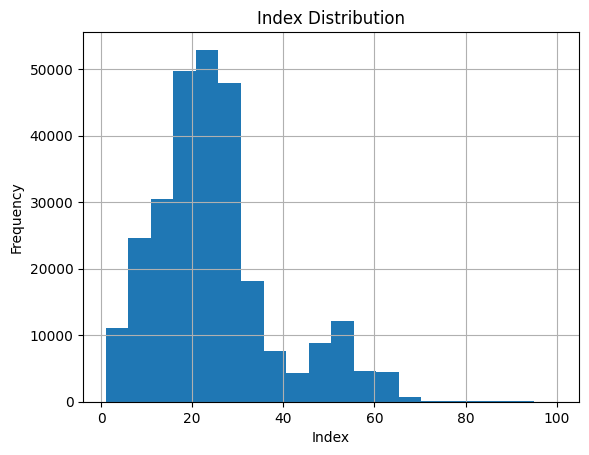

In [25]:
road_gdf["index"].hist(bins=20)
plt.xlabel("Index")
plt.ylabel("Frequency")
plt.title("Index Distribution")
plt.show()

Index(['id', 'name', 'way_type', 'index', 'index_10', 'stress_level', 'offset',
       'side', 'proc_width', 'proc_surface', 'proc_smoothness', 'proc_oneway',
       'proc_sidepath', 'proc_highway', 'proc_maxspeed',
       'proc_traffic_mode_left', 'proc_traffic_mode_right',
       'proc_separation_left', 'proc_separation_right', 'proc_buffer_left',
       'proc_buffer_right', 'proc_mandatory', 'proc_traffic_sign', 'fac_width',
       'fac_surface', 'fac_highway', 'fac_maxspeed', 'base_index', 'fac_1',
       'fac_2', 'fac_3', 'fac_4', 'data_bonus', 'data_malus',
       'data_incompleteness', 'data_missing', 'data_missing_width',
       'data_missing_surface', 'data_missing_smoothness',
       'data_missing_maxspeed', 'data_missing_parking', 'data_missing_lit',
       'filter_usable', 'filter_way_type', 'layer', 'path', 'geometry'],
      dtype='object')


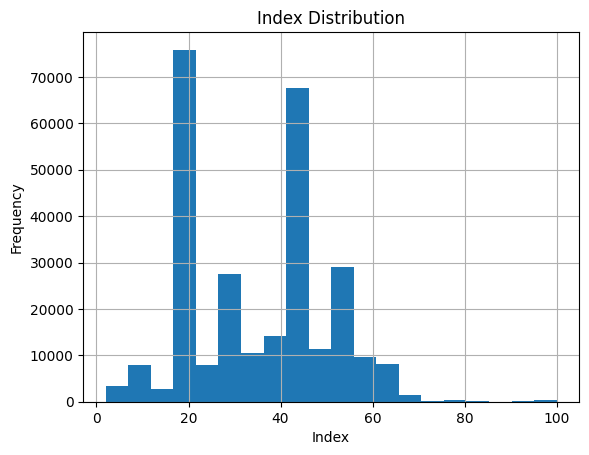

In [26]:
# 我们来比对一下
road_gdf_origin = gpd.read_file("/content/drive/MyDrive/CASA0004_Cycling/data/Roads/AAA.geojson")
print(road_gdf_origin.columns)

road_gdf_origin["index"].hist(bins=20)
plt.xlabel("Index")
plt.ylabel("Frequency")
plt.title("Index Distribution")
plt.show()